<a href="https://colab.research.google.com/github/irdazh/Final-Project/blob/main/final_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.10.12


# TA 02 -- Analisis Serius.

In [ ]:
# @title Library
import time
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# modeling
from sklearn.model_selection import train_test_split

# Create StratifiedKFold object.
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, average_precision_score, matthews_corrcoef, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


# based on 6 of them rec, pre, spe, f1s,  mat, and bal
!pip install scikit-posthocs
import scikit_posthocs as sp
from scipy import stats


import warnings
warnings.filterwarnings('ignore')

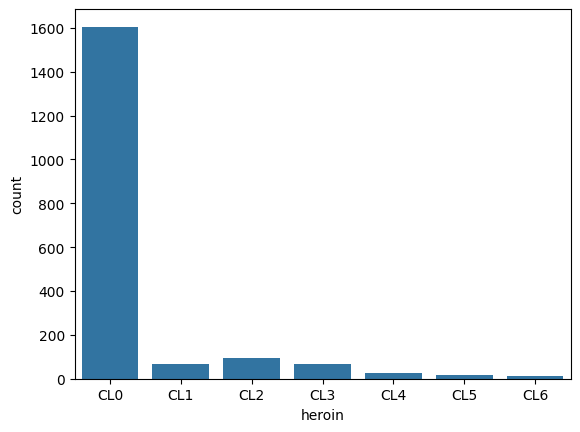

In [ ]:
# @title Read Data

from ucimlrepo import fetch_ucirepo

# fetch dataset
drug_consumption_quantified = fetch_ucirepo(id=373)

# data (as pandas dataframes) -- over a decade ago and never use
X = drug_consumption_quantified.data.features
y = drug_consumption_quantified.data.targets

y['heroin'] = pd.Categorical(y['heroin'], categories=["CL"+str(k) for k in np.arange(7)], ordered=True)
sns.countplot(x="heroin", data=y)

y.loc[:,"heroin"] = 0+(y.heroin >= "CL2")
y = y[["heroin"]].copy()


# so here is the features' data type
cat_var = (X.nunique()[X.nunique()<10]).index
num_var = X.columns.difference(cat_var)

for k in cat_var:
  X.loc[:, k] = X[k].replace(np.sort(X[k].unique()), np.arange(X[k].nunique()))


In [ ]:
np.sort(X[k].unique()), np.arange(X[k].nunique())


(array([0., 1., 2., 3., 4., 5., 6.]), array([0, 1, 2, 3, 4, 5, 6]))

In [ ]:
X.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss
0,2.0,1.0,5.0,6.0,5.0,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,1.0,0.0,8.0,6.0,2.0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,2.0,0.0,5.0,6.0,2.0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,0.0,1.0,7.0,6.0,2.0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,2.0,1.0,8.0,6.0,2.0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


# Viz and EDA
1. churn kinda imbalanced, pos vs neg &rarr; 1:5
2. churn kinda negatively related with customer value, distinct called number, frequency of sms, frequency of use, seconds of use [AND] tariff plan, charge amount
3. churn kinda positively related with complains, status
4. related with age-group but kinda complex; too young and too old less likely to churn



Narasi.



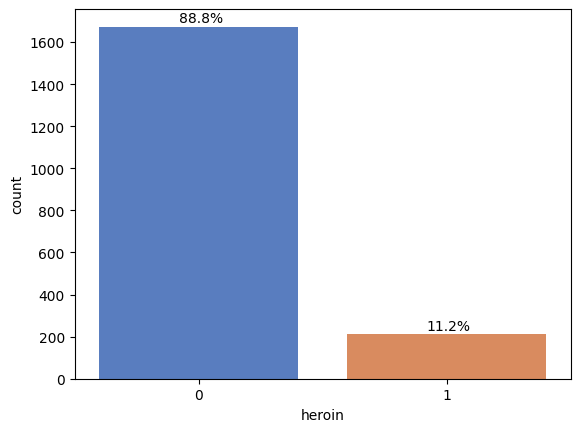

,count,mean,std,min,25%,50%,75%,max
heroin,1885.0,0.112467,0.316024,0.0,0.0,0.0,0.0,1.0


In [ ]:
# @title Target
def without_hue(plot, feature, yp=20):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.08
        y = p.get_y() + p.get_height() + yp
        ax.annotate(percentage, (x, y), size = 10)
    plt.show()

ax = sns.countplot(x="heroin", data=y, hue="heroin", palette="muted", legend=False)
without_hue(ax, y.heroin)

display(y.describe().transpose())

In [ ]:
# 8 times or what
print(1/y.heroin.mean() - 1, 1/7.89)

mmin = round(y.heroin.mean(), 2)
mmid = round(y.heroin.mean()/2+0.25, 2)

7.8915094339622645 0.1267427122940431


In [ ]:
X.join(y).sample(7, random_state=1).transpose()

,1828,510,1043,868,102,577,955
age,0.00000,3.00000,1.00000,1.00000,3.00000,3.00000,0.00000
gender,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000
education,3.00000,7.00000,7.00000,6.00000,3.00000,7.00000,4.00000
country,2.00000,6.00000,0.00000,0.00000,6.00000,6.00000,2.00000
ethnicity,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000
nscore,0.22393,0.41667,1.37297,0.91093,-0.58016,1.02119,-0.24649
escore,0.00332,0.47617,1.28610,-0.80615,1.28610,-0.15487,1.58487
oscore,0.44585,-0.17779,1.88511,1.06238,1.43533,0.29338,-0.01928
ascore,-0.91699,-0.15487,-2.53830,-0.45321,-1.34289,1.11406,-1.21213
cscore,-1.92173,0.25953,-1.25773,1.13407,-0.00665,1.46191,2.04506


## Features' desc
Info dropped here.
1. age -- 18, 25, 35, 45, 55, 65+
2. Male, Female
3. before 16, at 16, at 17, at 18, college or university but no certificate or degree, professional certificate/diploma, univeristy degree, masters degree, doctorate degree
4. country --- usa, new zealand, other, australia, republic of ireland, canada, uk
5. ethnicity --- black, asian, white, mixed white black, other, mixed white asian, mixed black asian

In [ ]:
X[cat_var].describe()

print(len(cat_var))
print(len(num_var))

display(np.round(X[num_var].describe(), 2))
# np.round(X[num_var].describe(), 2).to_latex()


5
7


,ascore,cscore,escore,impuslive,nscore,oscore,ss
count,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00,1885.00
mean,-0.00,-0.00,-0.00,0.01,0.00,-0.00,-0.00
std,1.00,1.00,1.00,0.95,1.00,1.00,0.96
min,-3.46,-3.46,-3.27,-2.56,-3.46,-3.27,-2.08
25%,-0.61,-0.65,-0.70,-0.71,-0.68,-0.72,-0.53
50%,-0.02,-0.01,0.00,-0.22,0.04,-0.02,0.08
75%,0.76,0.58,0.64,0.53,0.63,0.72,0.77
max,3.46,3.46,3.27,2.90,3.27,2.90,1.92


In [ ]:
np.round(X[cat_var].astype("category").describe(),0)


,age,gender,education,country,ethnicity
count,1885.0,1885.0,1885.0,1885.0,1885.0
unique,6.0,2.0,9.0,7.0,7.0
top,0.0,0.0,4.0,6.0,2.0
freq,643.0,943.0,506.0,1044.0,1720.0


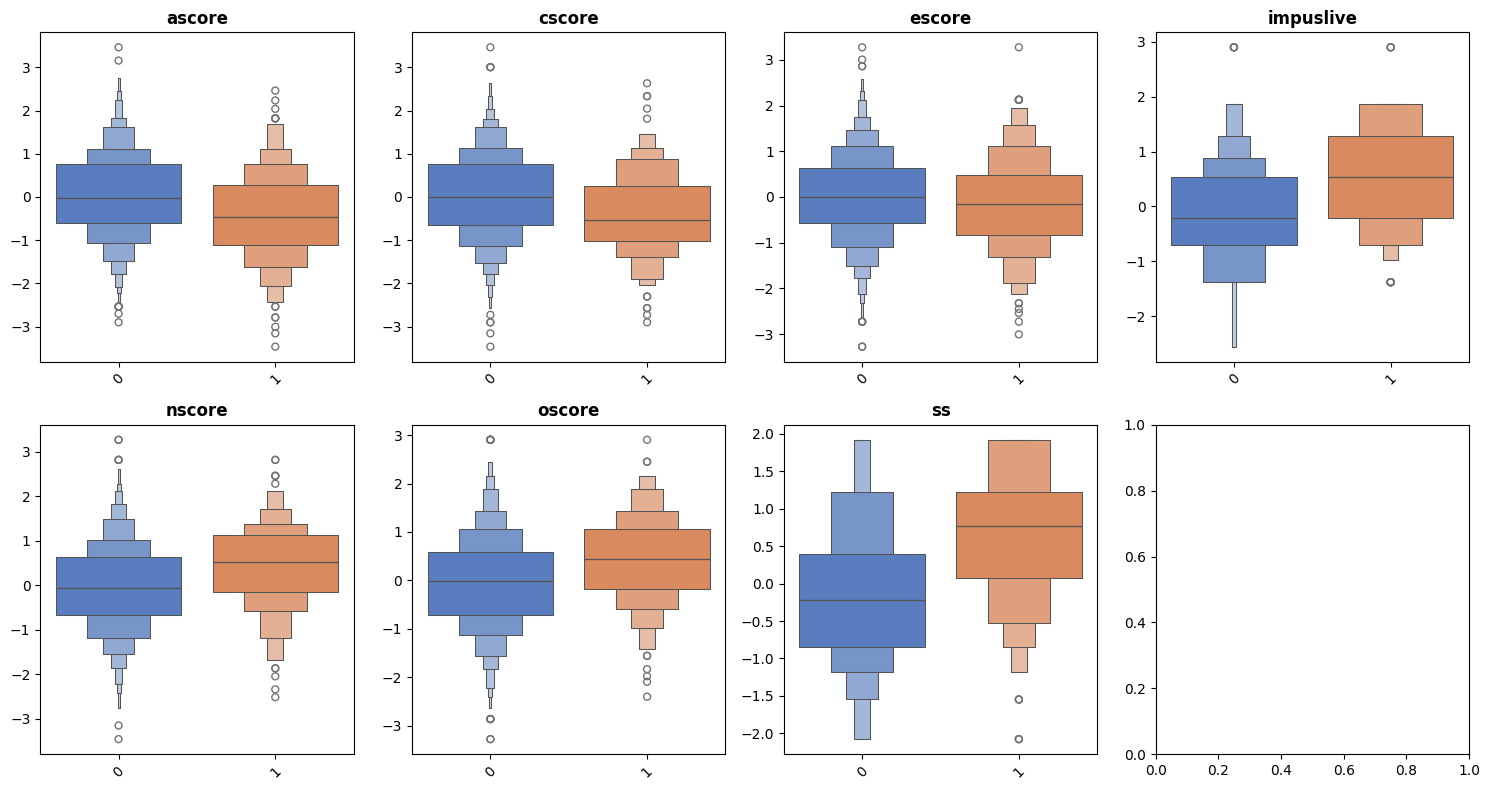

In [ ]:
# @title Numeric features vs target
fig, axes = plt.subplots(2, 4, figsize=(15, 8), sharey=False)
axes = axes.ravel()

for i, var in enumerate(num_var):
  sns.boxenplot(data=X.join(y), y=var, x="heroin", ax=axes[i], palette="muted", hue="heroin", legend=False)

  axes[i].set_title(f'{var}', fontsize=12, fontweight='bold')
  axes[i].set_xlabel(None)
  axes[i].set_ylabel('')
  axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


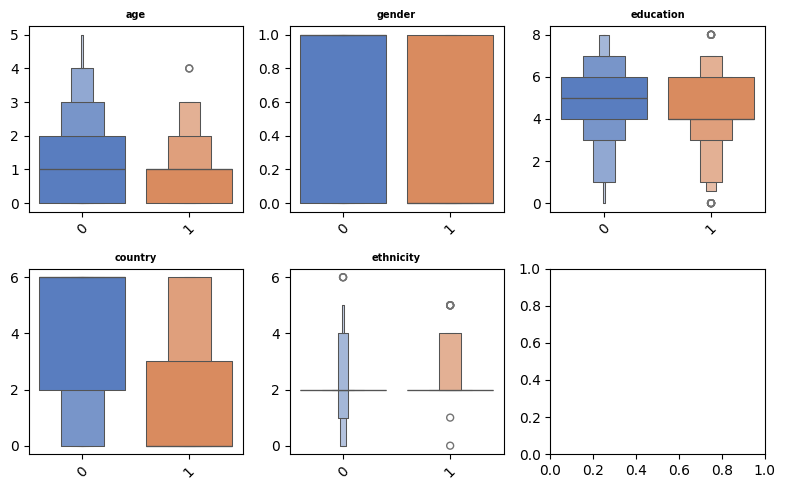

In [ ]:
# @title Categorical features vs target
fig, axes = plt.subplots(2, 3, figsize=(8, 5), sharey=False)
axes = axes.ravel()

for i, var in enumerate(cat_var):
  sns.boxenplot(data=X.join(y), y=var, x="heroin", ax=axes[i], palette="muted", hue="heroin", legend=False)

  axes[i].set_title(f'{var}', fontsize=7, fontweight='bold')
  axes[i].set_xlabel(None)
  axes[i].set_ylabel('')
  axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


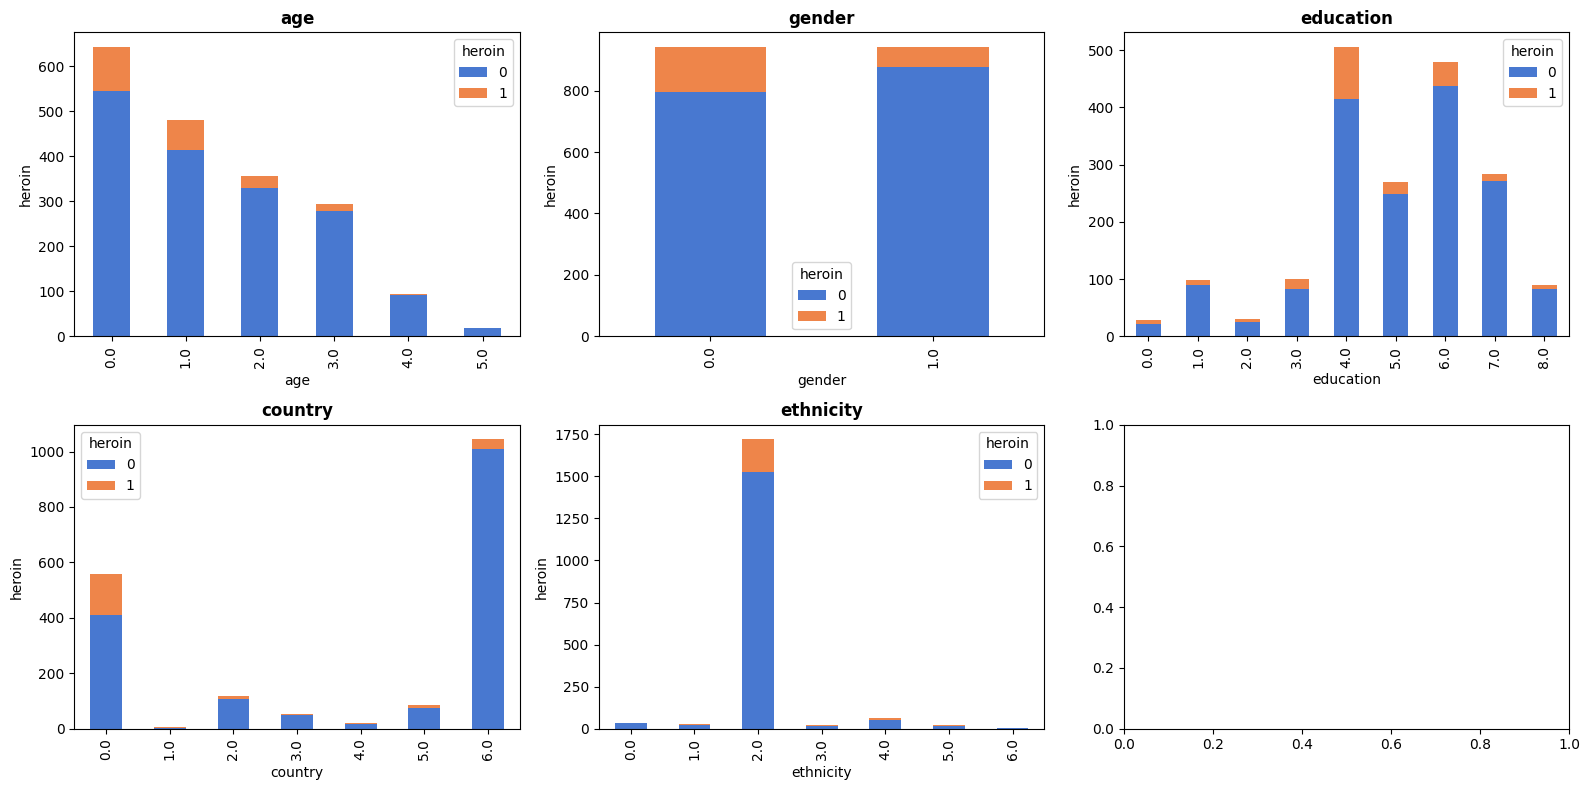

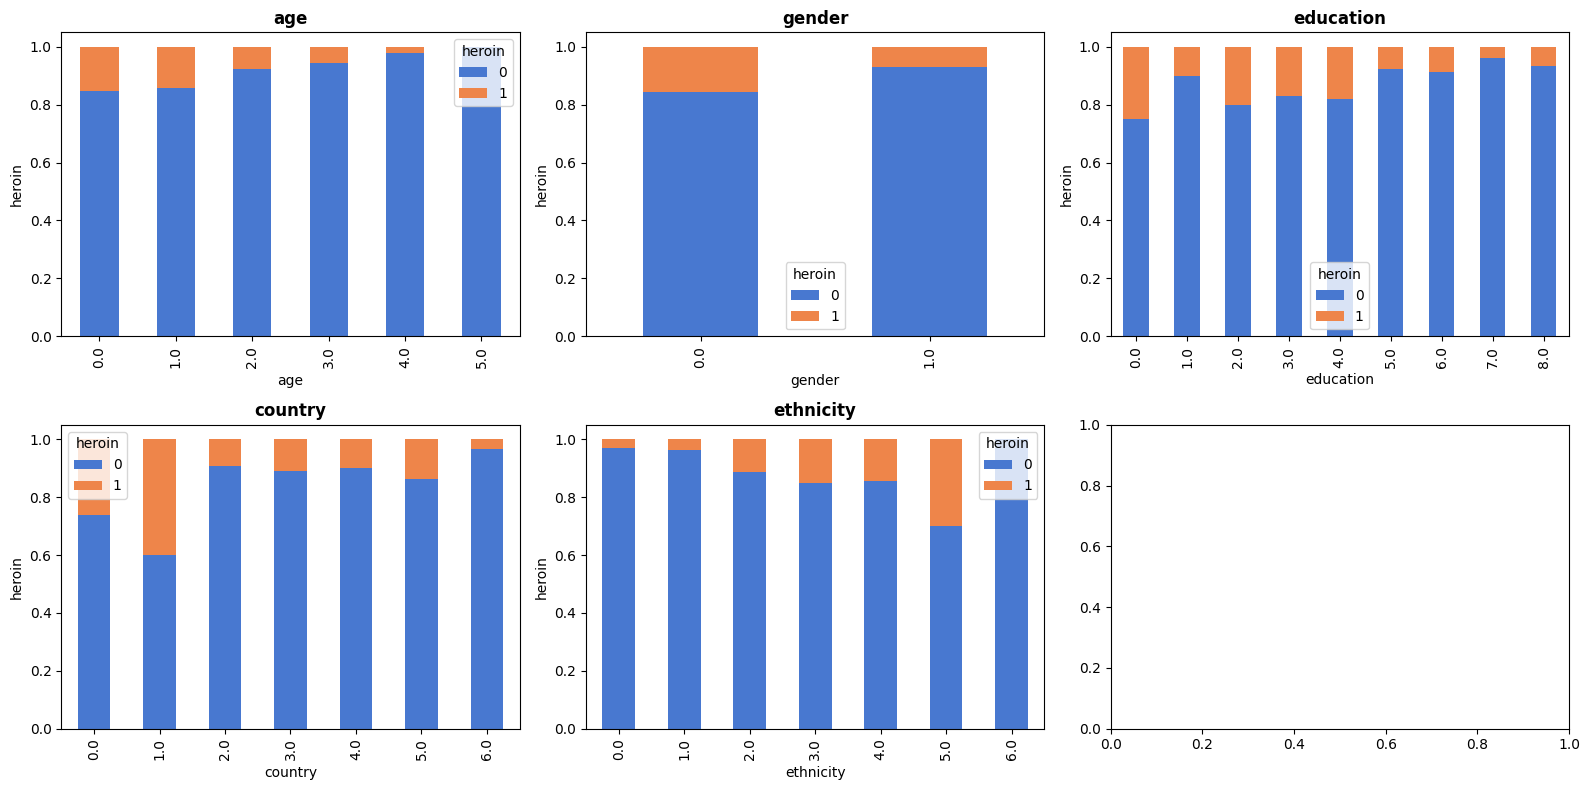

In [ ]:
# @title Categorical feature vs target 2
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=False)
axes = axes.ravel()

for i, var in enumerate(cat_var):

    tbl = pd.crosstab(X[var], y.heroin)
    tbl.plot(kind="bar", stacked=True,
             color=[sns.color_palette("muted").as_hex()[0],
                    sns.color_palette("muted").as_hex()[1]],
             ax=axes[i])

    axes[i].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('heroin')

plt.tight_layout()


fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=False)
axes = axes.ravel()

for i, var in enumerate(cat_var):

    tbl = pd.crosstab(X[var], y.heroin, normalize="index")
    tbl.plot(kind="bar", stacked=True,
             color=[sns.color_palette("muted").as_hex()[0],
                    sns.color_palette("muted").as_hex()[1]],
             ax=axes[i])

    axes[i].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('heroin')

plt.tight_layout()


# Modeling
1. train split, probably is no use - but still, use X_train and y_train
2. make rkf object
3. pilot smote -- 0.2, 0.9, sep 0.1, got 0.6 and 0.8
4. let's iterate, I guess, right? uhm no?
5.

In [ ]:
# @title Library for modeling
from sklearn import metrics

In [ ]:
# @title RKF object
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# # an example
# rf = RandomForestClassifier(random_state=0)
# lst_accu_stratified = []
# for train_index, test_index in skf.split(X, y):
#   sm = SMOTE(sampling_strategy=0.5, random_state=0) #0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
#   x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
#   y_train_fold, y_test_fold = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

#   rf.fit(x_train_fold, y_train_fold)
#   lst_accu_stratified.append(f1_score(y_test_fold, rf.predict(x_test_fold)))


In [ ]:
# #@title Pilot SMOTE

# an example
rf = RandomForestClassifier(random_state=0)
xg = GradientBoostingClassifier(random_state=0)


# def pilot_smote (model):

#   res = []
#   probs = np.round(np.arange(0.2, 1.1, 0.1),2)

#   for i in probs:
#     list_roc = []
#     list_prc = []

#     for train_index, test_index in skf.split(X, y):
#       sm = SMOTE(sampling_strategy=round(i,1), random_state=0)
#       x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
#       y_train_fold, y_test_fold = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

#       # resample
#       x_train_fold, y_train_fold = sm.fit_resample(x_train_fold, y_train_fold)

#       model.fit(x_train_fold, y_train_fold)
#       list_roc.append(roc_auc_score(y_test_fold, model.predict(x_test_fold)))
#       list_prc.append(average_precision_score(y_test_fold, model.predict(x_test_fold)))

#     res.append([np.mean(list_roc), np.mean(list_prc)])

#   res = np.array(res)
#   ret = [0, probs[np.argsort(res[:,0])[-1]], probs[np.argsort(res[:,1])[-1]], probs[np.argsort(res[:,1])[-2]] ]
#   if len(set(ret)) > 3: ret = ret[:3]

#   ret = np.array([k for k in set(ret)])

#   return np.round(ret, 2)

In [ ]:
# rf_prop = pilot_smote(model=rf)
# xg_prop = pilot_smote(model=xg)

# rf_prop, xg_prop

In [ ]:
def fLabel(pos_prob, thd):
  return (pos_prob >= thd).astype("int")

## Let's Iterate

In [ ]:
# an example
rf = RandomForestClassifier(random_state=0)
xg = GradientBoostingClassifier(random_state=0)
lr = LogisticRegression(max_iter=500)

mods = [rf, xg]

def modeling(models=mods):

  res_all = []
  for model in mods:
    print(model.__class__.__name__)

    for j, (train_index, test_index) in enumerate(skf.split(X, y)):

      x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
      y_train_fold, y_test_fold = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

      x_train_fold, x_valid_fold, y_train_fold, y_valid_fold = train_test_split(x_train_fold, y_train_fold, test_size=0.1, random_state=0, stratify=y_train_fold)


      model.fit(x_train_fold, y_train_fold)
      pred_tr = model.predict(x_train_fold)
      prob_tr = model.predict_proba(x_train_fold)

      prob_va = model.predict_proba(x_valid_fold)
      pred_va = model.predict(x_valid_fold)

      pred_te = model.predict(x_test_fold)
      prob_te = model.predict_proba(x_test_fold)

      roc = roc_auc_score(y_test_fold, pred_te)
      prc = average_precision_score(y_test_fold, pred_te)

      # proba things from training data -- 0.5, 0.33, f1 of 0.5/2, argmax of F1tr, balacc
      # np.round(0.345, 2)

      tprs, fprs, thrs = metrics.roc_curve(y_valid_fold, prob_va[:,1])

      temp = []
      for thr in thrs:
        pred = fLabel(prob_va[:,1], thr)
        pre = precision_score(y_valid_fold, pred)
        rec = recall_score(y_valid_fold, pred)
        f1m = metrics.fbeta_score(y_valid_fold, pred, beta=1)
        f2m = metrics.fbeta_score(y_valid_fold, pred, beta=2)
        gme = (recall_score(y_valid_fold, pred, pos_label=0)*rec)**0.5
        temp.append([thr, rec, f1m, gme])

      temp = np.array(temp)

      # now in the test data
      mdiv = np.round(f1_score(y_train_fold, pred_tr)/2, 2)
      mrec = temp[np.argmax(temp[:,1]), 0]
      mf1m = temp[np.argmax(temp[:,2]), 0]
      mgme = temp[np.argmax(temp[:,3]), 0]

      meths = [0.5, 0.33, mdiv, mrec, mf1m]
      meths = [0.5, mmin, mmid, mrec, mf1m, mgme]

      for meth, thr in enumerate(meths):
        pred = fLabel(prob_te[:,1], thr)
        acc = accuracy_score(y_test_fold, pred)
        rec = recall_score(y_test_fold, pred)
        pre = precision_score(y_test_fold, pred)
        spe = recall_score(y_test_fold, pred, pos_label=0)
        # mat = matthews_corrcoef(y_test_fold, pred)
        # bal = balanced_accuracy_score(y_test_fold, pred)
        f1m = metrics.fbeta_score(y_test_fold, pred, beta=1)
        gme = (spe*rec)**0.5
        # f2s = metrics.fbeta_score(y_test_fold, pred, beta=2)

        res_all.append([model.__class__.__name__, j, meth, thr, acc, rec, pre, spe, f1m, gme, roc, prc])

  res_all = pd.DataFrame(res_all)
  res_all.columns = "model fold method thr acc rec pre spe fme gme roc prc".split()
  res_all.method.replace([0,1,2,3,4,5], "STD Pmin MID optR optF optG".split(), inplace=True)

  return np.array([y_test_fold, prob_te[:,1]]), res_all


In [ ]:
prob_sam, mod_res = modeling()

RandomForestClassifier
GradientBoostingClassifier


<Axes: xlabel='real', ylabel='pred'>

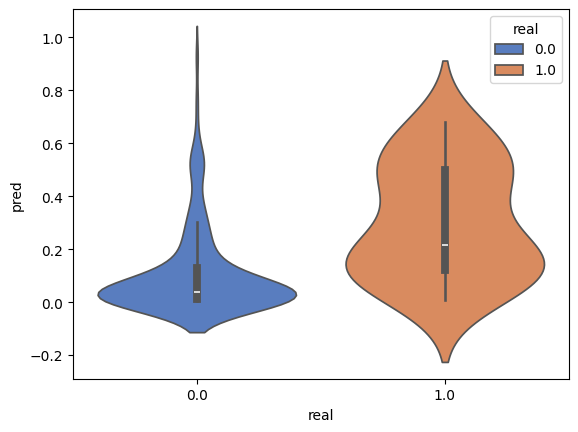

In [ ]:
dfg = pd.DataFrame(prob_sam[0], columns=["real"])

dfg["pred"] = prob_sam[1]
dfg

sns.violinplot(y='pred', x='real', data=dfg, palette="muted", hue="real")

<Axes: xlabel='pred', ylabel='Count'>

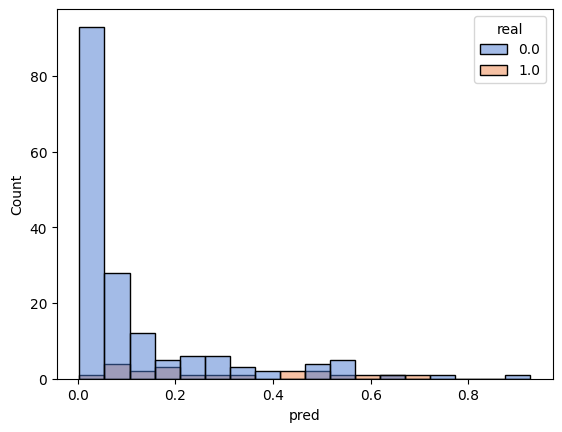

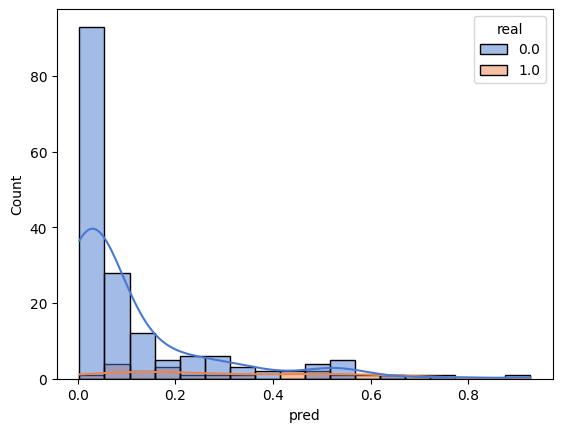

In [ ]:
sns.histplot(x='pred', data=dfg, palette="muted", hue="real")

plt.figure()
sns.histplot(x='pred', data=dfg, palette="muted", hue="real", kde=True)



<Axes: xlabel='pred'>

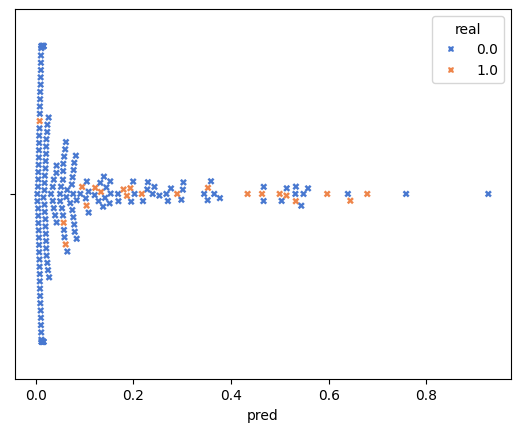

In [ ]:
sns.swarmplot(x='pred', data=dfg, palette="muted", hue="real", orient="h", marker="X")

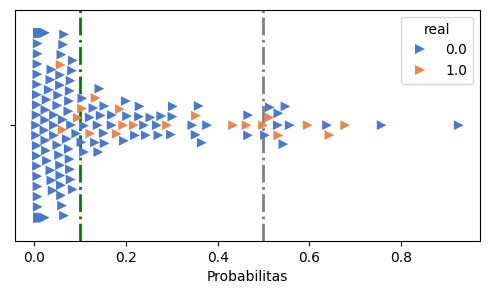

In [ ]:
plt.figure(figsize=(6,3))
sns.swarmplot(x='pred', data=dfg, palette="muted", hue="real", orient="h", marker=">", size=7)
plt.xlabel("Probabilitas")
plt.axvline(x=0.5, color='grey', linestyle='-.', linewidth=2)
plt.axvline(x=0.1, color='green', linestyle='-.', linewidth=2)


## Well, Methods and Metrics
1. method -- default, mmin, mmid, mopt (mrec, mf1s, mgme)
2. metrics used -- recall, f1s, and gmean
3. use nemenyi test or so dude

first overview
1. from akurasi, tell it that it is not suitable for imbalanced dataset
2. next into roc and prc auc metrics, that do not really depends on the threshold
3. for each rf and xg do compare: rec, f1s, gmean --
4. recall for catch all the heroin user, f1s and gmean to
5. nemenye test for those three and of course the graph as well.

In [ ]:
display(np.round(mod_res.groupby(['model', 'method']).mean(), 3))
np.round(mod_res.groupby(['model', 'method']).apply(lambda x: x.std()), 3)

fold    thr    acc    rec    pre    spe  \
model                      method                                            
GradientBoostingClassifier MID      4.5  0.310  0.842  0.294  0.308  0.912   
                           Pmin     4.5  0.110  0.726  0.695  0.247  0.730   
                           STD      4.5  0.500  0.879  0.123  0.397  0.974   
                           optF     4.5  0.197  0.792  0.524  0.276  0.826   
                           optG     4.5  0.103  0.706  0.719  0.241  0.705   
                           optR     4.5  0.022  0.397  0.954  0.157  0.327   
RandomForestClassifier     MID      4.5  0.310  0.840  0.318  0.311  0.906   
                           Pmin     4.5  0.110  0.653  0.813  0.220  0.632   
                           STD      4.5  0.500  0.884  0.071  0.332  0.987   
                           optF     4.5  0.221  0.775  0.546  0.266  0.805   
                           optG     4.5  0.150  0.707  0.687  0.226  0.710   
                           optR     4.5  0.033  0.400  0.944  0.157  0.331   

                                     fme    gme    roc    prc  
model                      method                              
GradientBoostingClassifier MID     0.296  0.509  0.549  0.148  
                           Pmin    0.364  0.708  0.549  0.148  
                           STD     0.182  0.340  0.549  0.148  
                           optF    0.353  0.641  0.549  0.148  
                           optG    0.357  0.704  0.549  0.148  
                           optR    0.268  0.539  0.549  0.148  
RandomForestClassifier     MID     0.311  0.527  0.527  0.142  
                           Pmin    0.346  0.714  0.527  0.142  
                           STD     0.106  0.192  0.527  0.142  
                           optF    0.341  0.632  0.527  0.142  
                           optG    0.338  0.686  0.527  0.142  
                           optR    0.267  0.518  0.527  0.142

fold    thr    acc    rec    pre    spe  \
model                      method                                             
GradientBoostingClassifier MID     3.028  0.000  0.029  0.104  0.120  0.028   
                           Pmin    3.028  0.000  0.045  0.146  0.045  0.047   
                           STD     3.028  0.000  0.011  0.052  0.103  0.015   
                           optF    3.028  0.074  0.050  0.185  0.069  0.066   
                           optG    3.028  0.035  0.066  0.164  0.047  0.085   
                           optR    3.028  0.010  0.132  0.071  0.027  0.152   
RandomForestClassifier     MID     3.028  0.000  0.036  0.117  0.125  0.031   
                           Pmin    3.028  0.000  0.047  0.128  0.033  0.052   
                           STD     3.028  0.000  0.010  0.101  0.336  0.012   
                           optF    3.028  0.073  0.071  0.260  0.083  0.103   
                           optG    3.028  0.033  0.035  0.213  0.042  0.054   
                           optR    3.028  0.026  0.142  0.080  0.027  0.167   

                                     fme    gme    roc    prc  
model                      method                              
GradientBoostingClassifier MID     0.100  0.102  0.022  0.021  
                           Pmin    0.067  0.081  0.022  0.021  
                           STD     0.056  0.064  0.022  0.021  
                           optF    0.103  0.136  0.022  0.021  
                           optG    0.060  0.072  0.022  0.021  
                           optR    0.039  0.133  0.022  0.021  
RandomForestClassifier     MID     0.114  0.113  0.040  0.038  
                           Pmin    0.050  0.062  0.040  0.038  
                           STD     0.128  0.191  0.040  0.038  
                           optF    0.106  0.152  0.040  0.038  
                           optG    0.073  0.104  0.040  0.038  
                           optR    0.037  0.198  0.040  0.038

In [ ]:
# sns.pairplot(mod_res.groupby(['model', 'method']).mean().reset_index(),hue="model")

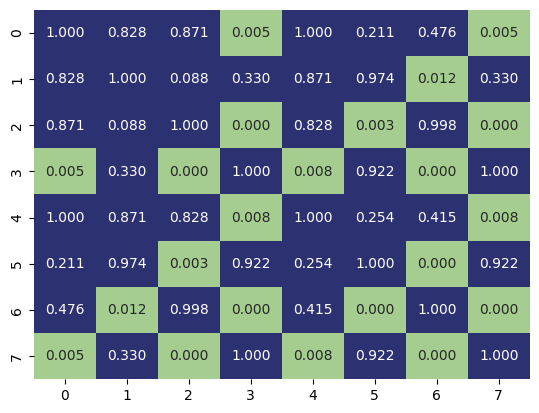

,0,1,2,3,4,5,6,7
0,1.00,0.83,0.87,0.01,1.00,0.21,0.48,0.01
1,0.83,1.00,0.09,0.33,0.87,0.97,0.01,0.33
2,0.87,0.09,1.00,0.00,0.83,0.00,1.00,0.00
3,0.01,0.33,0.00,1.00,0.01,0.92,0.00,1.00
4,1.00,0.87,0.83,0.01,1.00,0.25,0.42,0.01
5,0.21,0.97,0.00,0.92,0.25,1.00,0.00,0.92
6,0.48,0.01,1.00,0.00,0.42,0.00,1.00,0.00
7,0.01,0.33,0.00,1.00,0.01,0.92,0.00,1.00


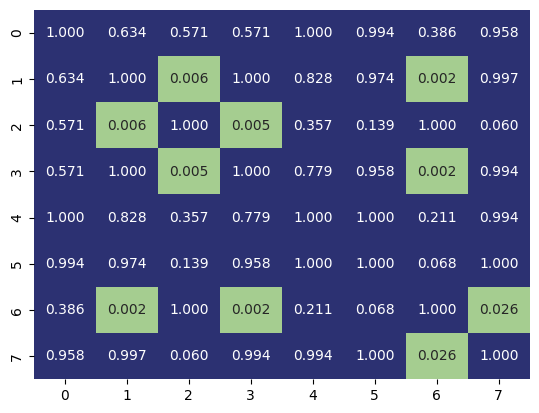

,0,1,2,3,4,5,6,7
0,1.00,0.63,0.57,0.57,1.00,0.99,0.39,0.96
1,0.63,1.00,0.01,1.00,0.83,0.97,0.00,1.00
2,0.57,0.01,1.00,0.00,0.36,0.14,1.00,0.06
3,0.57,1.00,0.00,1.00,0.78,0.96,0.00,0.99
4,1.00,0.83,0.36,0.78,1.00,1.00,0.21,0.99
5,0.99,0.97,0.14,0.96,1.00,1.00,0.07,1.00
6,0.39,0.00,1.00,0.00,0.21,0.07,1.00,0.03
7,0.96,1.00,0.06,0.99,0.99,1.00,0.03,1.00


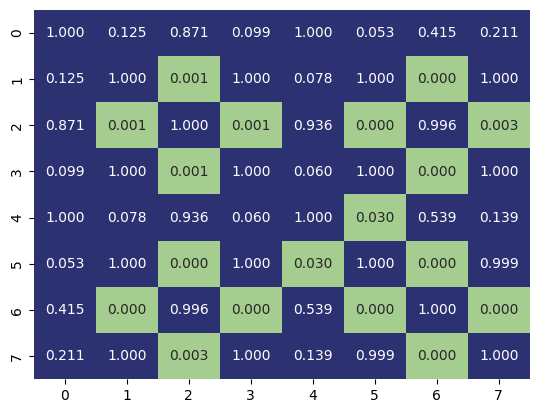

,0,1,2,3,4,5,6,7
0,1.00,0.12,0.87,0.10,1.00,0.05,0.42,0.21
1,0.12,1.00,0.00,1.00,0.08,1.00,0.00,1.00
2,0.87,0.00,1.00,0.00,0.94,0.00,1.00,0.00
3,0.10,1.00,0.00,1.00,0.06,1.00,0.00,1.00
4,1.00,0.08,0.94,0.06,1.00,0.03,0.54,0.14
5,0.05,1.00,0.00,1.00,0.03,1.00,0.00,1.00
6,0.42,0.00,1.00,0.00,0.54,0.00,1.00,0.00
7,0.21,1.00,0.00,1.00,0.14,1.00,0.00,1.00


In [ ]:
mod_f1m = mod_res[mod_res.method.isin("STD Pmin MID optF".split())].pivot(index=["model","method"], columns="fold", values="fme")
mod_rec = mod_res[mod_res.method.isin("STD Pmin MID optR".split())].pivot(index=["model","method"], columns="fold", values="rec")
mod_gme = mod_res[mod_res.method.isin("STD Pmin MID optG".split())].pivot(index=["model","method"], columns="fold", values="gme")


#perform Nemenyi post-hoc test
ntest = sp.posthoc_nemenyi_friedman(mod_rec.to_numpy().T)
sns.heatmap(ntest, annot=True, vmin = 0.049, vmax = 0.05, cmap='crest', cbar=False, fmt=".3f")
plt.show()

# 5, 6, 8, 13
display(round(ntest,2))

#perform Nemenyi post-hoc test
ntest = sp.posthoc_nemenyi_friedman(mod_f1m.to_numpy().T)
sns.heatmap(ntest, annot=True, vmin = 0.049, vmax = 0.05, cmap='crest', cbar=False, fmt=".3f")
plt.show()

# 5, 6, 8, 13
display(round(ntest,2))

#perform Nemenyi post-hoc test
ntest = sp.posthoc_nemenyi_friedman(mod_gme.to_numpy().T)
sns.heatmap(ntest, annot=True, vmin = 0.049, vmax = 0.05, cmap='crest', cbar=False, fmt=".3f")
plt.show()

display(round(ntest,2))

# 5, 6, 8, 13


In [ ]:
display(mod_rec, mod_f1m)


fold                                      0         1         2         3  \
model                      method                                           
GradientBoostingClassifier MID     0.333333  0.190476  0.285714  0.227273   
                           Pmin    0.714286  0.619048  0.619048  0.454545   
                           STD     0.095238  0.095238  0.095238  0.090909   
                           optR    1.000000  0.904762  1.000000  0.954545   
RandomForestClassifier     MID     0.333333  0.333333  0.285714  0.181818   
                           Pmin    0.904762  0.714286  0.714286  0.590909   
                           STD     0.047619  0.095238  0.095238  0.000000   
                           optR    1.000000  0.904762  0.761905  0.863636   

fold                                      4         5         6         7  \
model                      method                                           
GradientBoostingClassifier MID     0.090909  0.428571  0.285714  0.333333   
                           Pmin    0.500000  0.857143  0.761905  0.761905   
                           STD     0.090909  0.190476  0.095238  0.095238   
                           optR    0.772727  1.000000  0.952381  1.000000   
RandomForestClassifier     MID     0.090909  0.428571  0.428571  0.285714   
                           Pmin    0.727273  0.952381  0.904762  0.809524   
                           STD     0.000000  0.000000  0.047619  0.000000   
                           optR    0.954545  1.000000  1.000000  1.000000   

fold                                      8         9  
model                      method                      
GradientBoostingClassifier MID     0.333333  0.428571  
                           Pmin    0.904762  0.761905  
                           STD     0.142857  0.238095  
                           optR    1.000000  0.952381  
RandomForestClassifier     MID     0.333333  0.476190  
                           Pmin    1.000000  0.809524  
                           STD     0.095238  0.333333  
                           optR    1.000000  0.952381

fold                                      0         1         2         3  \
model                      method                                           
GradientBoostingClassifier MID     0.388889  0.181818  0.255319  0.256410   
                           Pmin    0.365854  0.361111  0.273684  0.303030   
                           STD     0.160000  0.133333  0.153846  0.148148   
                           optF    0.400000  0.121212  0.297297  0.352941   
RandomForestClassifier     MID     0.368421  0.291667  0.250000  0.200000   
                           Pmin    0.351852  0.319149  0.270270  0.309524   
                           STD     0.086957  0.173913  0.142857  0.000000   
                           optF    0.448980  0.333333  0.297872  0.260870   

fold                                      4         5         6         7  \
model                      method                                           
GradientBoostingClassifier MID     0.097561  0.375000  0.307692  0.400000   
                           Pmin    0.250000  0.444444  0.395062  0.410256   
                           STD     0.142857  0.285714  0.148148  0.160000   
                           optF    0.259740  0.434783  0.452830  0.426667   
RandomForestClassifier     MID     0.085106  0.450000  0.450000  0.315789   
                           Pmin    0.304762  0.412371  0.426966  0.354167   
                           STD     0.000000  0.000000  0.086957  0.000000   
                           optF    0.093023  0.389610  0.424242  0.400000   

fold                                      8         9  
model                      method                      
GradientBoostingClassifier MID     0.311111  0.382979  
                           Pmin    0.436782  0.395062  
                           STD     0.206897  0.277778  
                           optF    0.428571  0.360656  
RandomForestClassifier     MID     0.297872  0.400000  
                           Pmin    0.385321  0.320755  
                           STD     0.160000  0.411765  
                           optF    0.424242  0.337349

In [ ]:
mod_rec.rank().mean(axis=1)

model                       method
GradientBoostingClassifier  MID       3.40
                            Pmin      5.00
                            STD       1.90
                            optR      7.45
RandomForestClassifier      MID       3.50
                            Pmin      6.10
                            STD       1.20
                            optR      7.45
dtype: float64

In [ ]:
!pip install autorank
from autorank import autorank, plot_stats

  Preparing metadata (setup.py) ... done
  Created wheel for baycomp: filename=baycomp-1.0.3-py3-none-any.whl size=18030 sha256=9b6ceecc002136049b65a58a7ce59f51f63666062fb0e51860e829846f322c9f
  Stored in directory: /root/.cache/pip/wheels/8a/aa/61/8f1e79a2be629eaa2a72b495c56bb667568dac7c33f4e4c408
Successfully built baycomp


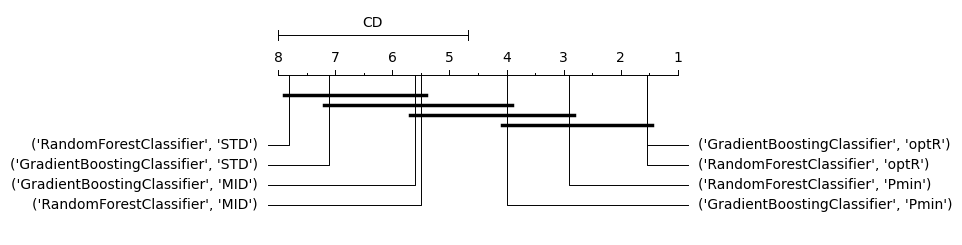

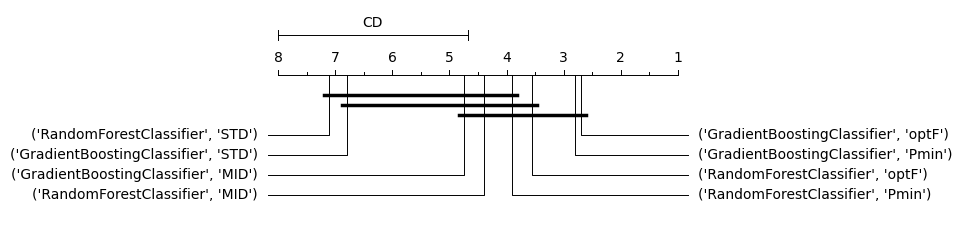

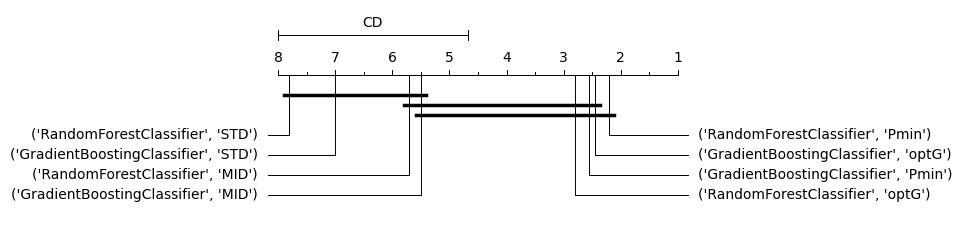

In [ ]:
result = autorank(mod_rec.T, alpha=0.05, verbose=False, order='descending')
plot_stats(result)
plt.show()

result = autorank(mod_f1m.T, alpha=0.05, verbose=False, order='descending')
plot_stats(result)
plt.show()

result = autorank(mod_gme.T, alpha=0.05, verbose=False, order='descending')
plot_stats(result)
plt.show()


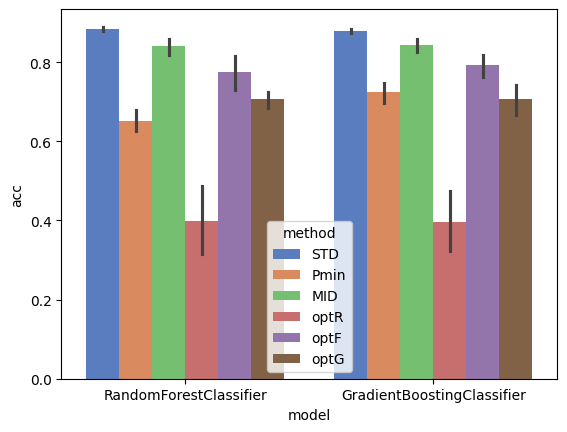

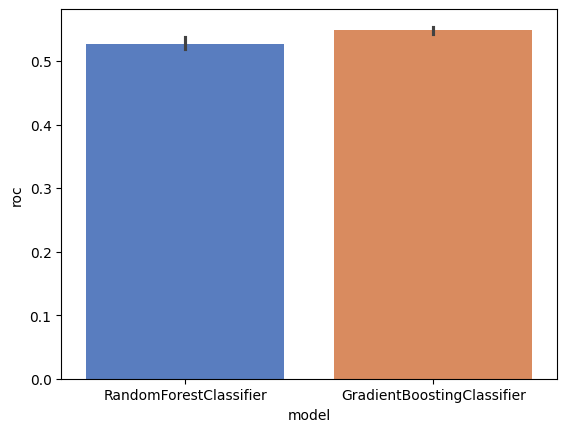

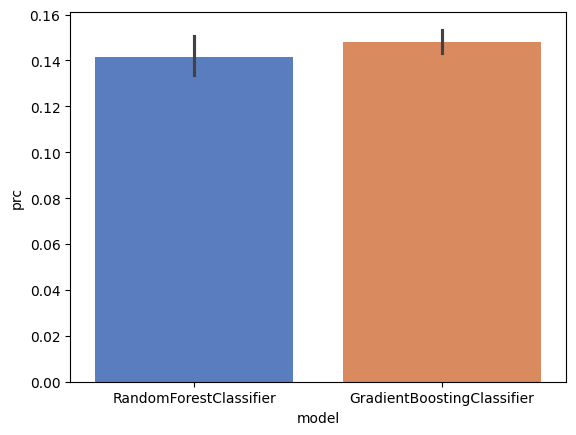

In [ ]:

for dt in [mod_res]:
  sns.barplot(y="acc", x="model", hue="method", data=dt, palette="muted")
  plt.show()

  sns.barplot(y="roc", x="model", hue="model",data=dt, palette="muted",legend=False)
  plt.show()

  sns.barplot(y="prc", x="model", hue="model", data=dt, palette="muted", legend=False)
  plt.show()


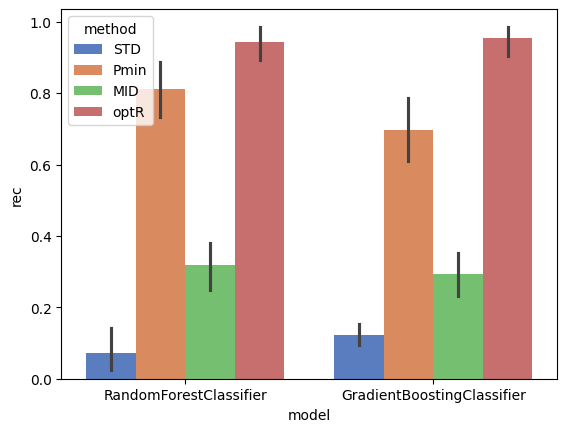

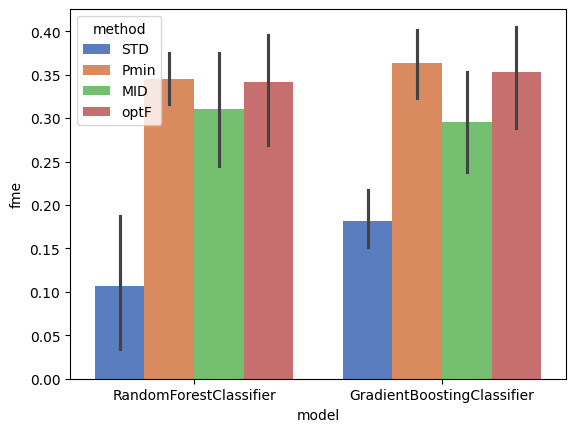

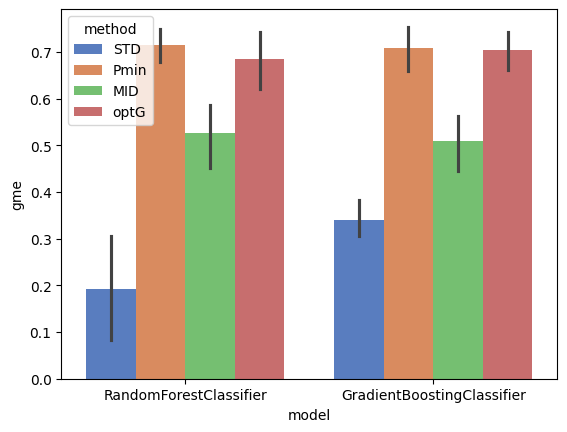

In [ ]:
for dt in [mod_res]:
  sns.barplot(y="rec", x="model", hue="method", data=dt[dt.method.isin("STD Pmin MID optR".split())], palette="muted")
  plt.show()

  sns.barplot(y="fme", x="model", hue="method", data=dt[dt.method.isin("STD Pmin MID optF".split())], palette="muted")
  plt.show()

  sns.barplot(y="gme", x="model", hue="method", data=dt[dt.method.isin("STD Pmin MID optG".split())], palette="muted")
  plt.show()


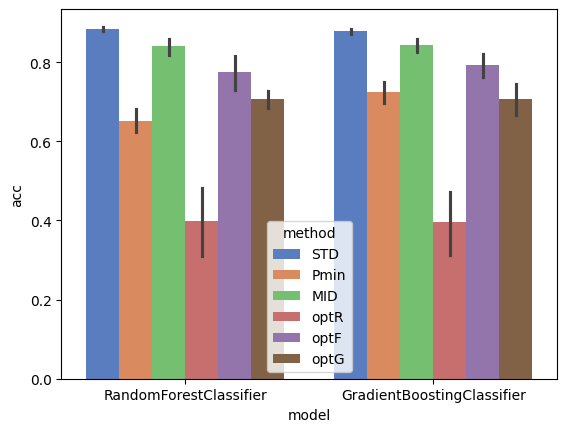

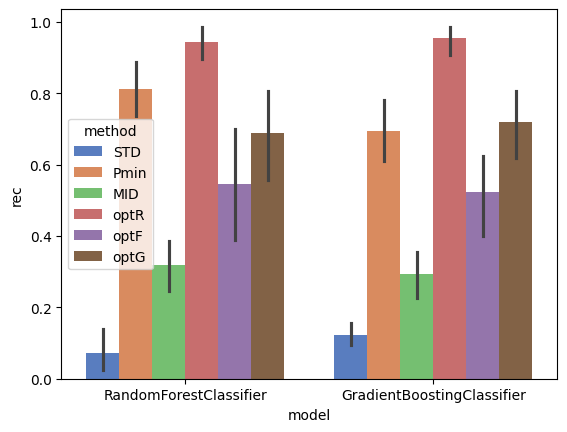

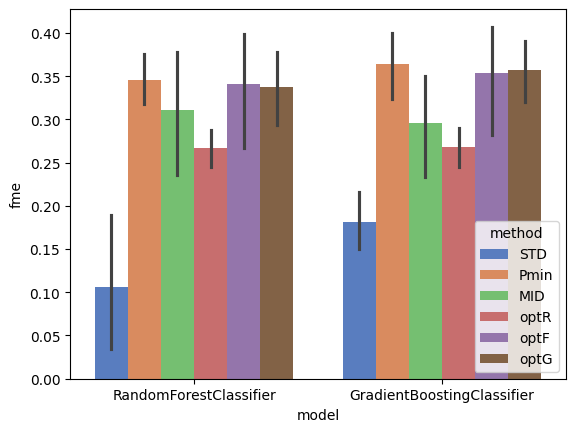

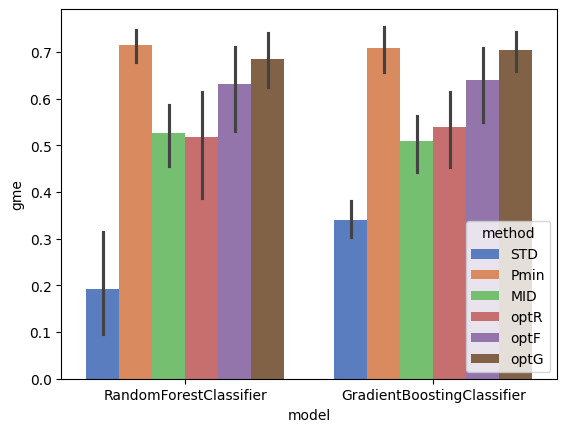

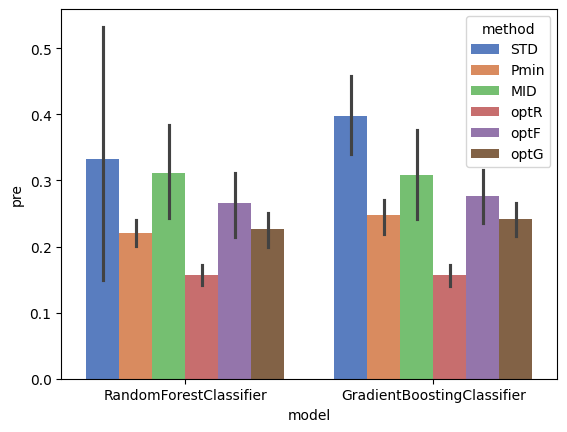

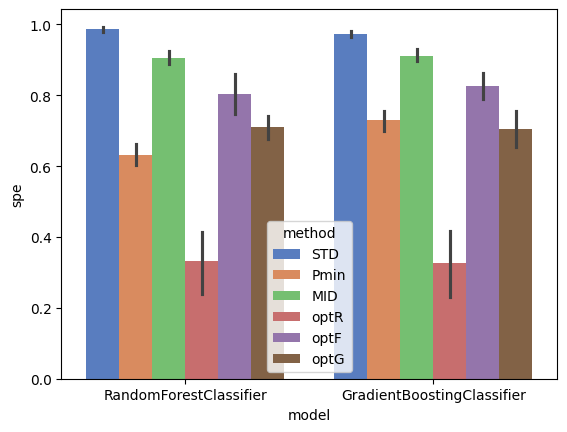

In [ ]:
for dt in [mod_res]:
  sns.barplot(y="acc", x="model", hue="method", data=dt, palette="muted")
  plt.show()

  sns.barplot(y="rec", x="model", hue="method", data=dt, palette="muted")
  plt.show()

  sns.barplot(y="fme", x="model", hue="method", data=dt, palette="muted")
  plt.show()

  sns.barplot(y="gme", x="model", hue="method", data=dt, palette="muted")
  plt.show()

  sns.barplot(y="pre", x="model", hue="method", data=dt, palette="muted")
  plt.show()

  sns.barplot(y="spe", x="model", hue="method", data=dt, palette="muted")
  plt.show()
